# Attention on VGGNet (Saliency and grad-CAM)

## Saliency

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear'.

In [1]:
from keras.applications import VGG16
from vis.utils import utils
from keras import activations

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


553476096/553467096 [==============================] - 5s 0us/step


/usr/local/lib/python2.7/dist-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [2]:
#%autoreload
from keras.preprocessing import image
from keras import applications
from keras.models import Sequential
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Conv2D, Conv3D,Input, ZeroPadding3D, Reshape
from keras.layers.convolutional import Convolution2D, Convolution3D, MaxPooling2D, ZeroPadding2D,ZeroPadding3D 
from keras.layers.core import Reshape
import os
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import CSVLogger
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.layers import Merge 
import numpy as np
import keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras import regularizers
from keras.utils import plot_model
#from keras.regularizers.Regularizer import kernal_regularizer
#import imp
#imp.reload(parse_data)

In [30]:
### Camera 1
#rgb
model_left = Sequential()
rgb_model_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(299,299,3))
model_left.add(rgb_model_vgg16)
model_left.get_layer(name='vgg16_input').name='vgg16_left_input'
model_left.get_layer(name='vgg16').name='vgg16_left'
#depth
model_right = Sequential()
depth_model_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(299,299,3))
model_right.add(depth_model_vgg16)
model_right.get_layer(name='vgg16_input').name='vgg16_right_input'
model_right.get_layer(name='vgg16').name='vgg16_right'



#merge
model = Sequential()
model.add(Merge([model_left,model_right], mode='concat'))  
model.add(Flatten())
#model.add(Dense(1024, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001),activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1024, activation='tanh'))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='tanh'))
model.add(Dense(512, activation='relu'))#,kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation = 'relu'))#,kernel_regularizer=regularizers.l2(0.001),activity_regularizer=regularizers.l1(0.001))) 
print(" DEBUG ")

Adm = keras.optimizers.Adam(lr = 0.00001)
model.compile(loss='mean_squared_error', optimizer=Adm,
            metrics=['mean_squared_error'])
model.summary()


 DEBUG 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_4 (Merge)              (None, 9, 9, 1024)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              84935680  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 1539      
To

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [29]:
object_path = "/home/ubuntu/CS230/train/"
dev_path = "/home/ubuntu/CS230/dev/"
filename ="vgg"
rescale=1. / 255
img_width, img_height = 299, 299
dev_num = 2
x_dev = np.empty([0,299,299,3])
d_dev = np.empty([0,299,299,3])
y_dev = np.empty([0,3])

for c in range(1,4):
    for k in range(dev_num):
        x_dev = np.load(dev_path+"cameraX.npy")
        d_dev = np.load(dev_path+"cameraD.npy")

        y_dev = np.load(dev_path+"cameraY.npy")

        #print(y_dev)


    
print y_dev.shape, np.min(y_dev),np.max(y_dev)
print x_dev.shape
print y_dev[0]

(252, 3) -1.4735804796218872 3.609727144241333
(252, 299, 299, 3)
[0.36287004 0.63130355 2.23632264]


In [33]:
def train(model):

    filepath_best="../weights_early_stopping.hdf5"
    #model.load_weights("../weights_best_plot1.hdf5")

    # load training value
    X = np.load(object_path+"cameraX.npy")
    D = np.load(object_path+"cameraD.npy")
    Y = np.load(object_path+"cameraY.npy")
    
    # output training step values for every batch. To baby-sit the training process
    def batchOutput(batch, logs):
        print("Finished batch: " + str(batch))
        print(logs)

    batchLogCallback = LambdaCallback(on_batch_end=batchOutput)
    
    checkpoint = ModelCheckpoint(filepath=filepath_best,monitor='loss', verbose=1,save_best_only=True, mode='min')
    res = model.fit([X,D], Y ,batch_size=32, epochs=1,verbose=2, shuffle=True,validation_data=([x_dev, d_dev], y_dev),callbacks=[checkpoint])
    plot_model(model, to_file='model.png')
    #res = model.fit([X,D], Y ,batch_size=32, epochs=3,verbose=1, shuffle=True,validation_split = 0.2)
    print("############HISTORY###############")
    print(str(res.history))




In [34]:
train(model)

Train on 1052 samples, validate on 252 samples
Epoch 1/1
 - 5641s - loss: 0.7393 - mean_squared_error: 0.7393 - val_loss: 0.3002 - val_mean_squared_error: 0.3002

Epoch 00001: loss improved from inf to 0.73929, saving model to ../weights_early_stopping.hdf5
############HISTORY###############
{'mean_squared_error': [0.7392929781072494], 'loss': [0.7392929781072494], 'val_mean_squared_error': [0.300221002764172], 'val_loss': [0.300221002764172]}


Lets load a couple of test images to try saliency.

In [40]:
from vis.utils import utils
from matplotlib import pyplot as plt
import cv2
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations
%matplotlib inline




plt.rcParams['figure.figsize'] = (18, 6)

layer_idx = utils.find_layer_idx(model, 'merge_4')

# read in rgb and depth images 
rgb_img_in = cv2.imread('../a.jpg', 1)
depth_img_in = cv2.imread('../a_d.jpg', 0)

# render color to depth image using heatmap
depth_img_raw = cv2.applyColorMap(depth_img_in, cv2.COLORMAP_JET)

# mean and std scale on both rgb and d    
rgb_mean = np.mean(rgb_img_in)
rgb_std = np.std(rgb_img_in) ** 2
rgb_img_raw = [(rgb_img_in[t]-rgb_mean)/rgb_std for t in range(len(rgb_img_in))]

depth_mean = np.mean(depth_img_raw)
depth_std = np.std(depth_img_raw) ** 2
depth_img_raw = [(depth_img_raw[t]-depth_mean)/depth_std for t in range(len(depth_img_raw))]                                                              
#print(len(depth_img_raw))

grad1,grad2 = visualize_saliency(model, layer_idx, filter_indices=20, seed_input=[rgb_img_raw,depth_img_raw], backprop_modifier='relu')
f, ax = plt.subplots(1, 2)
ax[0].imshow(grad1)
ax[1].imshow(grad2)

ValueError: You are trying to load a weight file containing 5 layers into a model with 3 layers.

Time for saliency visualization.

TypeError: Can not convert a list into a Tensor or Operation.

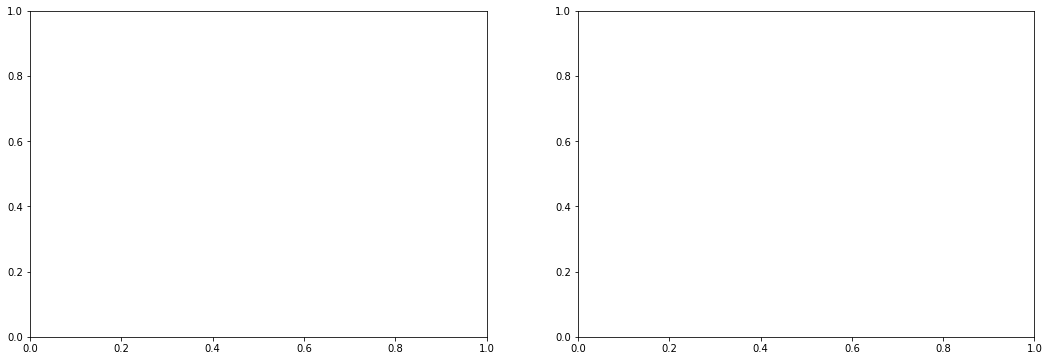

In [7]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_2')

f, ax = plt.subplots(1, 2)
#for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
grads1, grades2 = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=[img1,img2])
    
    # visualize grads as heatmap
ax[0].imshow(grads1, cmap='jet')
ax[1].imshow(grads2, cmap='jet')

Not that great. Very noisy. Lets try guided and rectified saliency.

To use guided saliency, we need to set `backprop_modifier='guided'`. For rectified saliency or deconv saliency, use `backprop_modifier='relu'`.

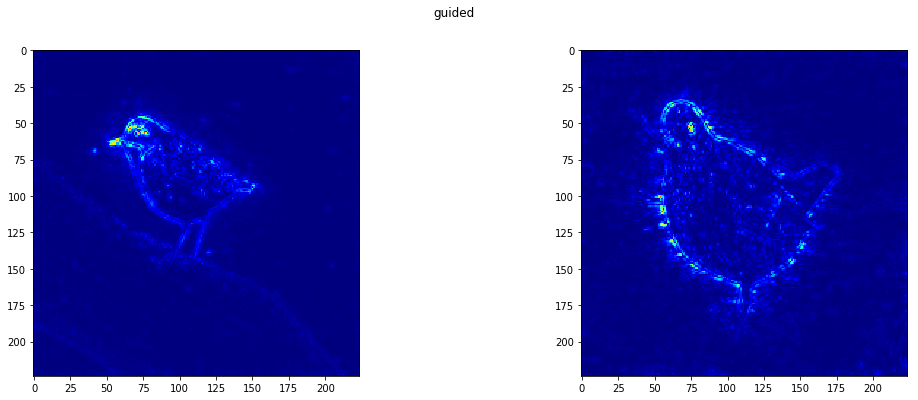

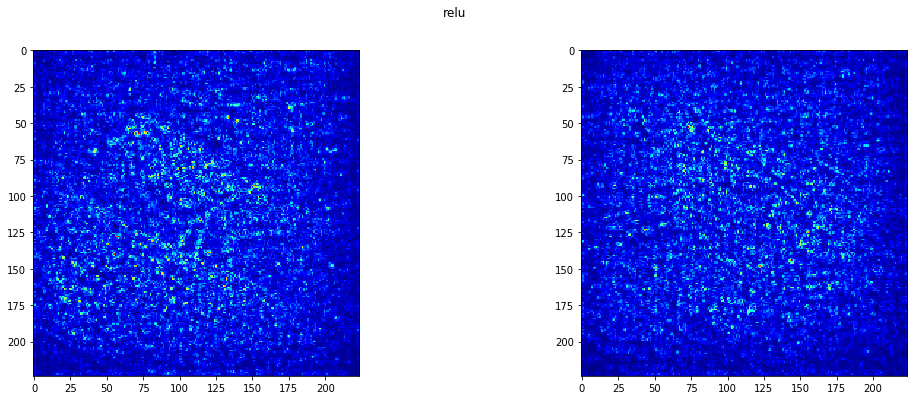

In [7]:
for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_saliency(model, layer_idx, filter_indices=20, 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')

guided saliency is definitely better. I am not sure whats going on with rectified saliency.

## grad-CAM - vanilla, guided, rectified

These should contain more detail since they use `Conv` or `Pooling` features that contain more spatial detail which is lost in `Dense` layers. The only additional detail compared to saliency is the `penultimate_layer_idx`. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if `penultimate_layer_idx` is not defined, it searches for the nearest pre layer. For our architecture, that would be the `block5_pool` layer after all the `Conv` layers. Here is the model summary for reference.

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

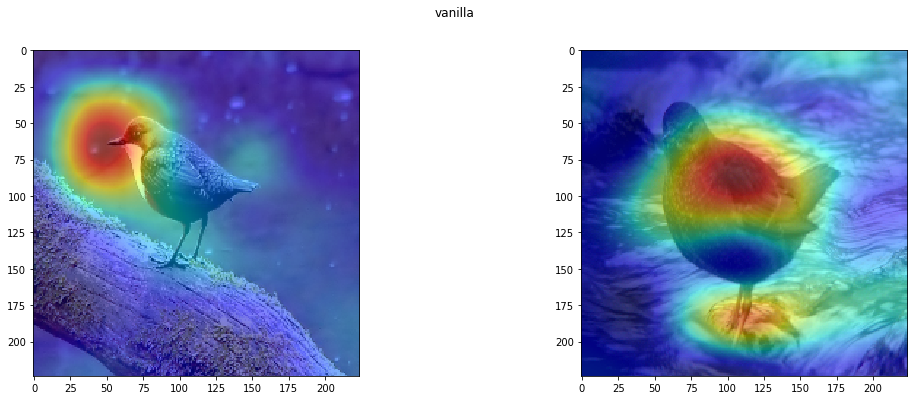

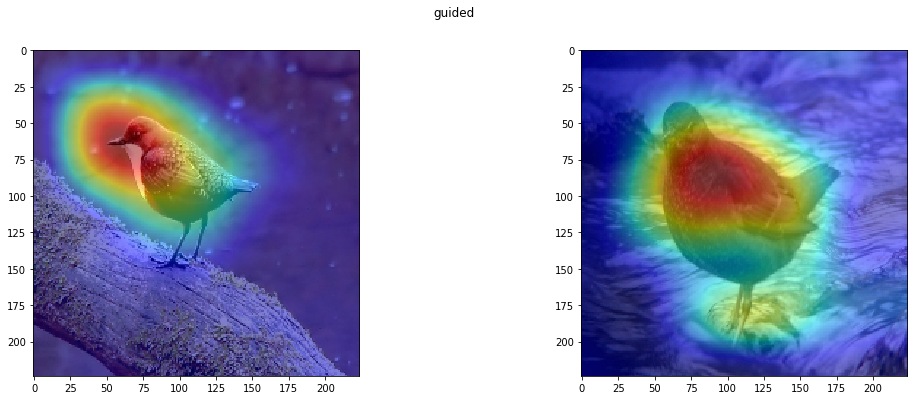

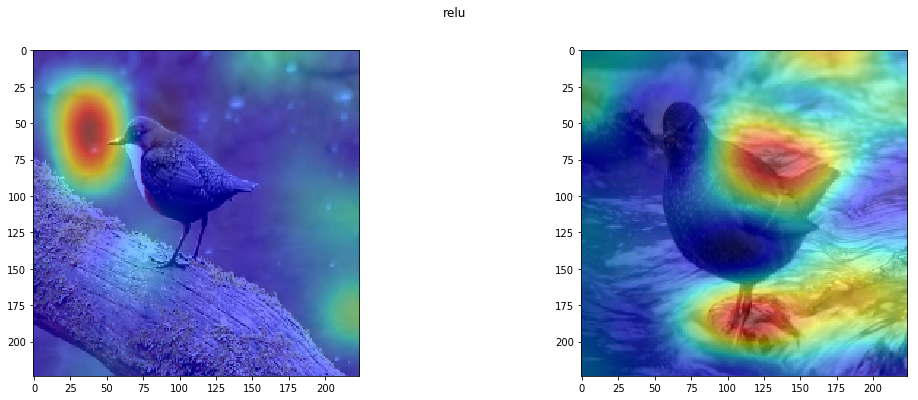

In [14]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=20, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

guided grad-CAM wins again. It far less noisy than other options.